In [2]:
!pip install leidenalg
!pip install netgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 4.8 MB/s eta 0:00:00


In [1]:
import leidenalg
import networkx as nx
import igraph as ig
import community.community_louvain as cl
import numpy as np
import seaborn as sns
from networkx.algorithms.community import modularity
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
import matplotlib.pyplot as plt

In [2]:
def partition_statistics(G, partition, show_cluster_size_dist=True):
    cluster_num = len(partition)
    cluster_sizes = [len(c) for c in partition]
    min_size, max_size, mean_size, median_size = np.min(cluster_sizes), np.max(cluster_sizes), np.mean(
        cluster_sizes), np.median(cluster_sizes)
    singletons = [c for c in partition if len(c) == 1]
    singletons_num = len(singletons)
    non_singleton_num = len(partition) - len(singletons)
    modularity_score = modularity(G, partition)
    coverage = (G.number_of_nodes() - len(singletons)) / G.number_of_nodes()

    print('#clusters in partition:', cluster_num)
    if show_cluster_size_dist:
        print(sorted(cluster_sizes, reverse=True))
    print('min, max, mean, median cluster sizes:', min_size, max_size, mean_size, median_size)
    print('number of singletons:', singletons_num)
    print('number of non-singleton clusters:', non_singleton_num)
    print('modularity:', modularity_score)
    print('coverage:', coverage)

    return cluster_num, min_size, max_size, mean_size, median_size, singletons_num, non_singleton_num, modularity_score, coverage

def evaluate_partition(graph, method_name, partition):
    print('\n'+method_name)
    cluster_num, min_size, max_size, mean_size, median_size, singletons_num, non_singleton_num, modularity_score, coverage = partition_statistics(
        graph, partition)

def group_to_partition(partition):
    part_dict = {}
    for index, value in partition.items():
        if value in part_dict:
            part_dict[value].append(index)
        else:
            part_dict[value] = [index]
    return part_dict.values()

def membership_list_to_dict(membership_list):
    membership_dict = {}
    for i in range(len(membership_list)):
        membership_dict[i] = membership_list[i]
    return membership_dict

def get_membership_list_from_dict(membership_dict):
    memberships = []
    for i in range(len(membership_dict)):
        memberships.append(membership_dict[i])
    return memberships

def communities_to_dict(communities):
    result = {}
    community_index = 0
    for c in communities:
        community_mapping = ({node: community_index for index, node in enumerate(c)})
        result = {**result, **community_mapping}
        community_index += 1
    return result

In [24]:
def initialize(graph, value):
    for u, v in graph.edges():
        graph[u][v]['weight'] = value
    return graph

def get_communities(graph, algorithm, seed):
    if algorithm == 'louvain':
        return cl.best_partition(graph, random_state=seed, weight='weight')
    elif algorithm == 'leiden-cpm':
        return communities_to_dict(leidenalg.find_partition(ig.Graph.from_networkx(graph),
                                                  leidenalg.CPMVertexPartition,
                                                  resolution_parameter=0.001,
                                                  n_iterations=2).as_cover())
    elif algorithm == 'leiden-mod':
        return communities_to_dict(leidenalg.find_partition(ig.Graph.from_networkx(graph),
                                        leidenalg.ModularityVertexPartition,
                                        weights='weight',
                                        seed=seed).as_cover())

def check_convergence(G, n_p, delta):
    count = 0
    for wt in nx.get_edge_attributes(G, 'weight').values():
        if wt != 0 and wt != n_p:
            count += 1
    if count > delta * G.number_of_edges():
        return False
    return True

def thresholding(graph, n_p, thresh):
    remove_edges = []
    for u, v in graph.edges():
        if graph[u][v]['weight'] < thresh * n_p:
            remove_edges.append((u, v))
    graph.remove_edges_from(remove_edges)
    return graph


def simple_consensus(G, algorithm='leiden', n_p=10, thresh=0.9, delta=0.02, max_iter=10):
    graph = G.copy()
    graph = initialize(graph, 1.0)
    iter_count = 0

    while True:
        iter_count += 1
        if iter_count > max_iter:
            iter_count -= 1
            break
        nextgraph = graph.copy()
        nextgraph = initialize(nextgraph, 0.0)
        partitions = [get_communities(graph, algorithm, i) for i in range(n_p)]

        # print('edges', len(graph.edges()))
        for i in range(n_p):
            # print('np: ', i)
            c = partitions[i]
            for node, nbr in graph.edges():
                if graph[node][nbr]['weight'] not in (0, n_p):
                    if c[node] == c[nbr]:
                        nextgraph[node][nbr]['weight'] += 1
                else:
                    nextgraph[node][nbr]['weight'] = graph[node][nbr]['weight']
                # print(node, nbr, nextgraph[node][nbr]['weight'])

        nextgraph = thresholding(nextgraph, n_p, thresh)
        if check_convergence(nextgraph, n_p, delta=delta):
            break
        graph = nextgraph.copy()

    print('number of iterations:', iter_count)
    return group_to_partition(get_communities(graph, algorithm, 0)), iter_count

In [25]:
def false_negative():
    return

def false_positive():
    return

def strict_consensus(G, algorithm='leiden', n_p=20):
    graph = G.copy()
    graph = initialize(graph, 1.0)
    iter_count = 0

    partitions = [get_communities(graph, algorithm, i) for i in range(n_p)]

    for i in range(n_p):
        c = partitions[i]
        for node, nbr in graph.edges():
            if c[node] != c[nbr]:
                graph[node][nbr]['weight'] = 0

    graph = thresholding(graph, 1, 1)

    return group_to_partition(get_communities(graph, algorithm, 0))

## Resolution Limit of Modularity

In [17]:
ring = nx.ring_of_cliques(num_cliques=100, clique_size=10)

In [5]:
print(ring)

Graph with 1000 nodes and 4600 edges


In [6]:
nx.write_edgelist(ring, "ring_cliques_100_10.tsv", data=False)

In [7]:
print(ring.number_of_edges())

4600


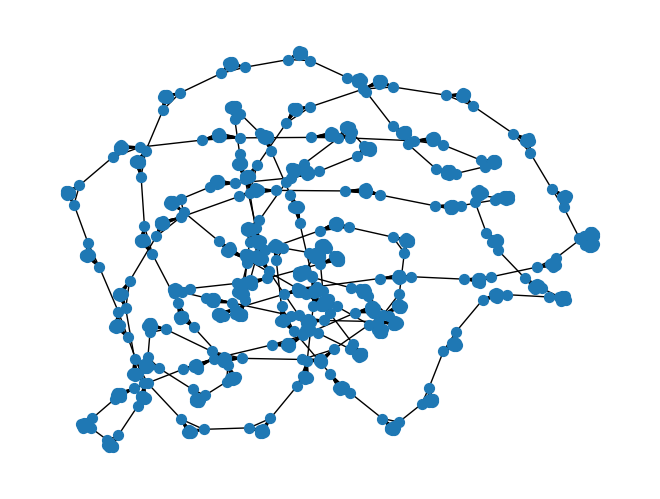

In [ ]:
nx.draw(ring, node_size=50)

In [ ]:
leiden_mod = leidenalg.find_partition(ig.Graph.from_networkx(ring),
                                        leidenalg.ModularityVertexPartition,
                                        seed=1234).as_cover()
leiden_cpm = leidenalg.find_partition(ig.Graph.from_networkx(ring),
                                                 leidenalg.CPMVertexPartition,
                                                 resolution_parameter=0.0001,
                                                 n_iterations=2).as_cover()
louvain1 = group_to_partition(cl.best_partition(ring))
louvain2 = group_to_partition(cl.best_partition(ring))

In [ ]:
stict_louvain = strict_consensus(ring, algorithm='louvain', n_p = 40)

4600
4500
number of iterations: 0


In [ ]:
stict_leiden = strict_consensus(ring, algorithm='leiden', n_p = 50)

4600
4500
number of iterations: 0


In [ ]:
evaluate_partition(ring, 'leiden-MOD', leiden_mod)

#clusters in partition: 58
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
min, max, mean, median cluster sizes: 10 20 17.24137931034483 20.0
number of singletons: 0
number of non-singleton clusters: 58
modularity: 0.9689913043478271
coverage: 1.0


In [ ]:
evaluate_partition(ring, 'leiden-CPM', leiden_cpm)

#clusters in partition: 8
[150, 140, 130, 130, 120, 120, 110, 100]
min, max, mean, median cluster sizes: 100 150 125.0 125.0
number of singletons: 0
number of non-singleton clusters: 8
modularity: 0.8714608695652174
coverage: 1.0


In [ ]:
adjusted_mutual_info_score(get_membership_list_from_dict(communities_to_dict(louvain2)), get_membership_list_from_dict(communities_to_dict(louvain1)))

0.8596047210304227

In [ ]:
evaluate_partition(ring, 'Louvain', louvain1)

#clusters in partition: 55
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 10, 20, 20, 20, 20, 20, 20, 20, 10, 20, 20, 20, 20, 20, 20, 20, 10, 20, 20, 10, 20, 20, 20, 20, 10, 20, 20, 20, 10, 20, 20, 20, 20, 10, 20, 20, 20, 20, 10, 20, 20, 10, 20, 10]
min, max, mean, median cluster sizes: 10 20 18.181818181818183 20.0
number of singletons: 0
number of non-singleton clusters: 55
modularity: 0.9690434782608707
coverage: 1.0


In [ ]:
evaluate_partition(ring, 'Louvain', louvain2)

#clusters in partition: 55
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 10, 20, 20, 20, 20, 20, 20, 20, 20, 20, 10, 20, 10, 20, 20, 10, 20, 20, 10, 20, 20, 20, 10, 20, 20, 20, 10, 20, 10, 20, 20, 10, 20, 20, 20, 20, 20, 10, 20, 20, 20, 20]
min, max, mean, median cluster sizes: 10 20 18.181818181818183 20.0
number of singletons: 0
number of non-singleton clusters: 55
modularity: 0.9690434782608707
coverage: 1.0


In [ ]:
evaluate_partition(ring, 'Strict-Louvain', stict_louvain)

#clusters in partition: 100
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
min, max, mean, median cluster sizes: 10 10 10.0 10.0
number of singletons: 0
number of non-singleton clusters: 100
modularity: 0.9682608695652182
coverage: 1.0


In [ ]:
evaluate_partition(ring, 'Strict-Leiden-MOD', stict_leiden)

#clusters in partition: 100
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
min, max, mean, median cluster sizes: 10 10 10.0 10.0
number of singletons: 0
number of non-singleton clusters: 100
modularity: 0.9682608695652182
coverage: 1.0


consensus clustering slows down reaching the resolution limit? the higher the n_p, the better this corrects resolution limit
the resolution value in CPM also matters

### Non-clusterable networks

In [5]:
def gen_tree_of_cliques(k, n):
  '''
  k: size of clique
  n: number of cliques
  '''
  cliques = [nx.complete_graph(k) for _ in range(n)]
  tree = nx.random_tree(n)
  tree_of_cliques = nx.disjoint_union_all(cliques)
  for s, d in tree.edges():
    tree_of_cliques.add_edge(s*k+4, d*k)
  return tree_of_cliques

In [6]:
tree_of_cliques=gen_tree_of_cliques(k=10, n=100)
nx.write_edgelist(tree_of_cliques, "tree_of_cliques_k10_n100.txt", data=False)

In [7]:
erdos_renyi_graph = nx.gnm_random_graph(n=tree_of_cliques.number_of_nodes(), m=tree_of_cliques.number_of_edges())

erdos reyni on its own is dissolved using strict consensus, but when combined with a ring of cliques or an lfr graph, it is always clustered as a single cluster -- why? does it depend on the relative density of the erdos-renyi, or do we always see this trend?

yes density matters! if erdos-renyi is not dense, then strict consensus does make it disolve... but otherwise, it will be seen as a single cluster

look at the consensus matrix as a heatmap...

KeyboardInterrupt: 

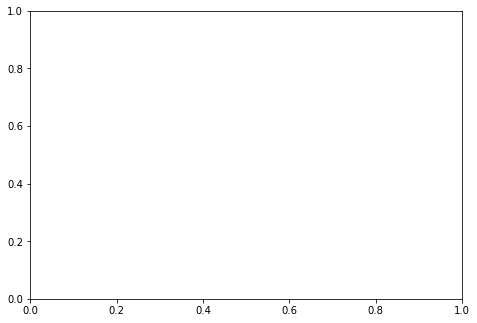

In [8]:
nx.draw(erdos_renyi_graph, node_size=20)

In [9]:
avg_degree = 2*tree_of_cliques.number_of_edges()/1000
avg_degree

9.198

In [10]:
lfr = nx.generators.community.LFR_benchmark_graph(n=1000, tau1=3, tau2=1.5, mu=0.1, average_degree=avg_degree, min_community =45, seed =10)

In [11]:
communities = {frozenset(lfr.nodes[v]["community"]) for v in lfr}

In [12]:
sorted([len(c) for c in communities])

[45, 47, 57, 59, 60, 61, 70, 74, 74, 87, 88, 91, 91, 96]

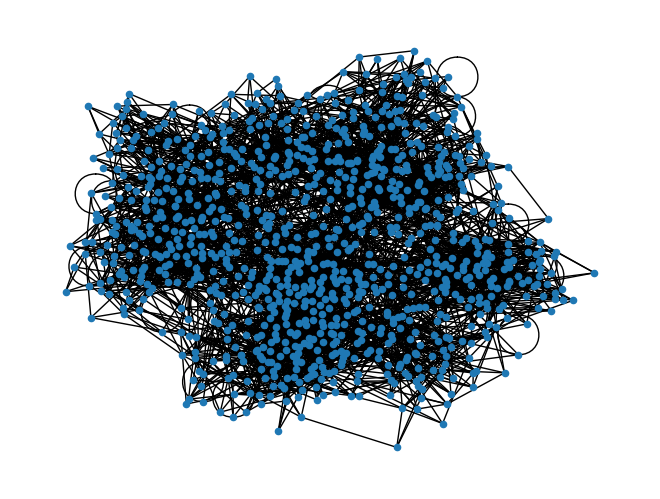

In [ ]:
nx.draw(lfr, node_size=20)

In [13]:
lfr.number_of_edges()

4236

In [14]:
erdos_renyi_graph = nx.erdos_renyi_graph(n=1000, p=0.002)

In [15]:
lfr_plus_erdos_renyi = nx.disjoint_union_all([erdos_renyi_graph, lfr])
lfr_plus_erdos_renyi.add_edge(0, lfr_plus_erdos_renyi.number_of_nodes()-1)

In [48]:
ring_plus_erdos_renyi = nx.disjoint_union_all([ring, erdos_renyi_graph])
ring_plus_erdos_renyi.add_edge(0, ring_plus_erdos_renyi.number_of_nodes()-1)

In [19]:
lfr_plus_erdos_renyi.number_of_edges(), lfr_plus_erdos_renyi.number_of_nodes()

(5260, 2000)

In [20]:
ring_plus_erdos_renyi.number_of_edges(), ring_plus_erdos_renyi.number_of_nodes()

(5624, 2000)

In [21]:
erdos_renyi_graph.number_of_edges(), erdos_renyi_graph.number_of_nodes()

(1023, 1000)

In [ ]:
print(tree_of_cliques.number_of_edges())
print(tree_of_cliques.number_of_nodes())

4599
1000


In [ ]:
ring5_4 = nx.ring_of_cliques(num_cliques=30, clique_size=5)
tree = nx.random_tree(20)
ring_tree = nx.disjoint_union_all([ring5_4, tree])
ring_tree.add_edge(0, ring_tree.number_of_nodes()-1)

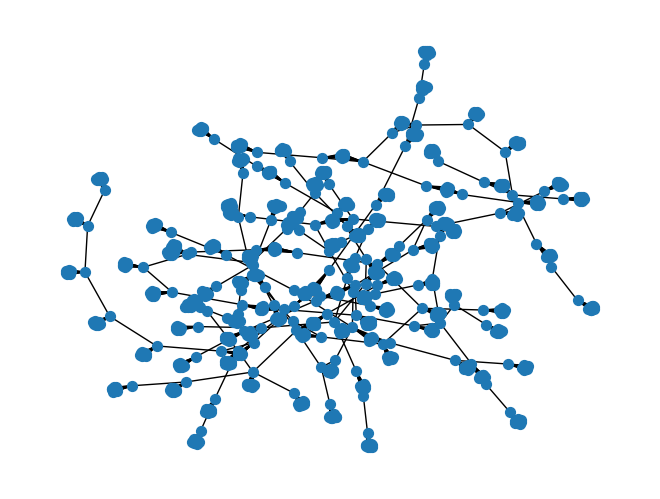

In [ ]:
nx.draw(tree_of_cliques, node_size=50)

tree of cliques is very different from ring of cliques... why? we can solve the problem of resolution limit on a ring, but not on a tree?

In [32]:
def compare_clusterings(net):
  print('running leiden modularity...')
  leiden_mod = leidenalg.find_partition(ig.Graph.from_networkx(net),
                                        leidenalg.ModularityVertexPartition,
                                        seed=1234).as_cover()
  print('running leiden CPM...')
  leiden_cpm = leidenalg.find_partition(ig.Graph.from_networkx(net),
                                                  leidenalg.CPMVertexPartition,
                                                  resolution_parameter=0.001,
                                                  n_iterations=2).as_cover()
  print('running louvain...')
  louvain = group_to_partition(cl.best_partition(net))
  print('running strict leiden-MOD, np=10...')
  strict_leiden = strict_consensus(net, algorithm='leiden-mod', n_p = 10)
  print('running strict leiden-MOD, np=50...')
  strict_leiden_50 = strict_consensus(net, algorithm='leiden-mod', n_p = 50)
  #print('running strict leiden-CPM...')
  #strict_leiden_cpm = strict_consensus(net, algorithm='leiden-cpm', n_p = 50)
  #print('running strict louvain...')
  #strict_louvain = strict_consensus(net, algorithm='louvain', n_p = 50)


  evaluate_partition(net, 'leiden-MOD', leiden_mod)
  evaluate_partition(net, 'Strict-Leiden-MOD=10', strict_leiden)
  evaluate_partition(net, 'Strict-Leiden-MOD=50', strict_leiden_50)
    
  #evaluate_partition(net, 'leiden-CPM', leiden_cpm)
  #evaluate_partition(net, 'Strict-Leiden-CPM', strict_leiden_cpm)
  #evaluate_partition(net, 'Louvain', louvain)
  #evaluate_partition(net, 'Strict-Louvain', strict_louvain)


[45, 47, 57, 59, 60, 61, 70, 74, 74, 87, 88, 91, 91, 96]

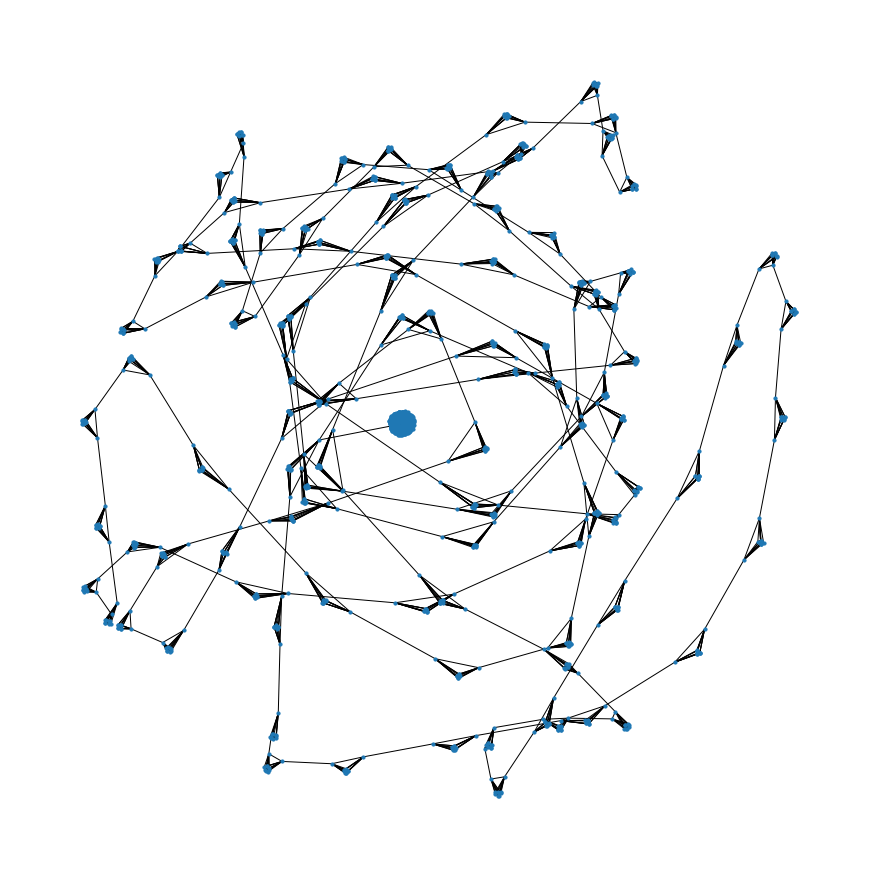

In [52]:
plt.figure(3,figsize=(12,12)) 
nx.draw(ring_plus_erdos_renyi, node_size=10)
plt.show()

In [43]:
erdos_renyi_graph = nx.erdos_renyi_graph(n=1000, p=0.1)
lfr_plus_erdos_renyi = nx.disjoint_union_all([erdos_renyi_graph, lfr])
lfr_plus_erdos_renyi.add_edge(0, lfr_plus_erdos_renyi.number_of_nodes()-1)

compare_clusterings(lfr_plus_erdos_renyi)

running leiden modularity...
running leiden CPM...
running louvain...
running strict leiden-MOD, np=10...
running strict leiden-MOD, np=50...

leiden-MOD
#clusters in partition: 6
[1000, 278, 204, 190, 165, 163]
min, max, mean, median cluster sizes: 163 1000 333.3333333333333 197.0
number of singletons: 0
number of non-singleton clusters: 6
modularity: 0.1638927274354649
coverage: 1.0

Strict-Leiden-MOD=10
#clusters in partition: 1010
[96, 91, 91, 88, 87, 74, 72, 71, 62, 61, 59, 57, 47, 44, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [49]:
compare_clusterings(ring_plus_erdos_renyi)

running leiden modularity...
running leiden CPM...
running louvain...
running strict leiden-MOD, np=10...
running strict leiden-MOD, np=50...

leiden-MOD
#clusters in partition: 25
[245, 218, 185, 179, 173, 60, 60, 60, 60, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 40, 40, 40, 40]
min, max, mean, median cluster sizes: 40 245 80.0 50.0
number of singletons: 0
number of non-singleton clusters: 25
modularity: 0.1763952137393357
coverage: 1.0

Strict-Leiden-MOD=10
#clusters in partition: 1086
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
erg = nx.gnm_random_graph(n=tree_of_cliques.number_of_nodes(), m=tree_of_cliques.number_of_edges())
compare_clusterings(erg)

running leiden modularity...
running leiden CPM...
running louvain...
running strict leiden-MOD...
running strict leiden-CPM...
running strict louvain...

leiden-MOD
#clusters in partition: 15
[97, 72, 72, 71, 69, 69, 68, 68, 66, 64, 64, 62, 60, 54, 44]
min, max, mean, median cluster sizes: 44 97 66.66666666666667 68.0
number of singletons: 0
number of non-singleton clusters: 15
modularity: 0.3172591194063998
coverage: 1.0

Strict-Leiden-MOD
#clusters in partition: 996
[3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
print('less dense erdos renyi graph...\n')
erg = nx.gnm_random_graph(n=tree_of_cliques.number_of_nodes(), m=tree_of_cliques.number_of_edges()/2)
compare_clusterings(erg)

less dense erdos renyi graph...

running leiden modularity...
running leiden CPM...
running louvain...
running strict leiden-MOD...
running strict leiden-CPM...
running strict louvain...

leiden-MOD
#clusters in partition: 39
[78, 77, 64, 58, 58, 56, 55, 55, 54, 54, 54, 53, 52, 51, 50, 47, 35, 28, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
min, max, mean, median cluster sizes: 1 78 25.641025641025642 1.0
number of singletons: 21
number of non-singleton clusters: 18
modularity: 0.4774890359168242
coverage: 0.979

Strict-Leiden-MOD
#clusters in partition: 952
[3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
compare_clusterings(gen_tree_of_cliques(k=10, n=1000)) #n_p=50

running leiden modularity...
running leiden CPM...
running louvain...
running strict leiden-MOD...
running strict leiden-CPM...
running strict louvain...

leiden-MOD
#clusters in partition: 225
[70, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3

In [ ]:
compare_clusterings(nx.ring_of_cliques(num_cliques=1000, clique_size=10))

running leiden modularity...
running leiden CPM...
running louvain...
running strict leiden-MOD...
running strict leiden-CPM...
running strict louvain...

leiden-MOD
#clusters in partition: 225
[60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 4

for leiden CPM, you see the effect of consensus clustering when the resolution parameter is largest?

In [ ]:
r_values = [1, 0.5, 0.1, 0.01, 0.001, 0.0001]
leiden_cpm_clusterings = [leidenalg.find_partition(ig.Graph.from_networkx(net),
                                                leidenalg.CPMVertexPartition,
                                                resolution_parameter=r,
                                                n_iterations=2).as_cover() for r in r_values]

In [ ]:
list(reversed(sns.color_palette("Paired", 20).as_hex()))

['#ff7f00',
 '#fdbf6f',
 '#e31a1c',
 '#fb9a99',
 '#33a02c',
 '#b2df8a',
 '#1f78b4',
 '#a6cee3',
 '#b15928',
 '#ffff99',
 '#6a3d9a',
 '#cab2d6',
 '#ff7f00',
 '#fdbf6f',
 '#e31a1c',
 '#fb9a99',
 '#33a02c',
 '#b2df8a',
 '#1f78b4',
 '#a6cee3']

<ipython-input-63-93b5109cb7c5>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw(ring_tree, node_size=50, node_color=list(communities_to_dict(stict_leiden).values()), cmap = plt.cm.get_cmap('Paired'))


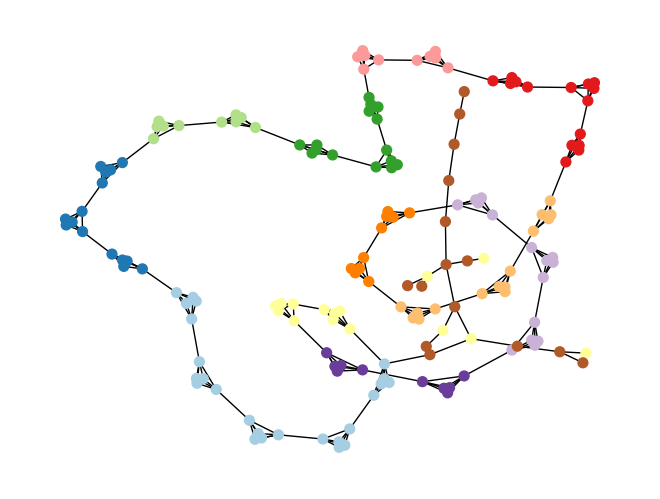

In [ ]:
nx.draw(ring_tree, node_size=50, node_color=list(communities_to_dict(stict_leiden).values()), cmap = plt.cm.get_cmap('Paired'))

<ipython-input-82-f56ea9fdb502>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.cm.get_cmap('Paired')


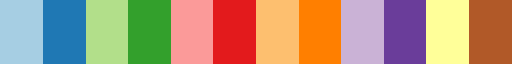

In [ ]:
plt.cm.get_cmap('Paired')

<ipython-input-74-d6afa6abd253>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw(ring_tree, node_size=50, node_color=list(communities_to_dict(leiden_mod).values()), cmap = plt.cm.get_cmap('Paired'))


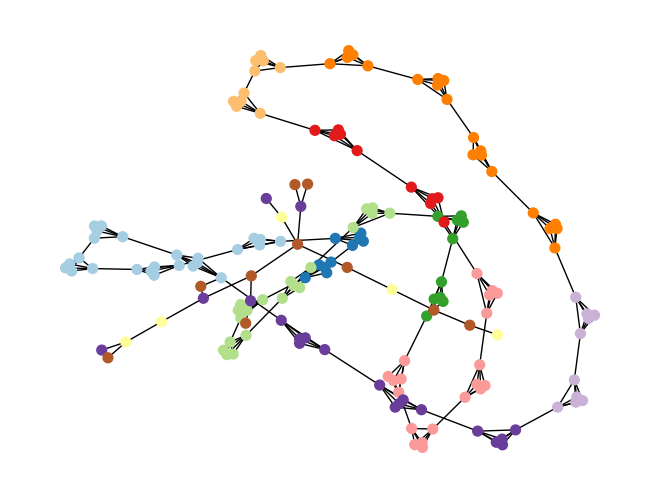

In [ ]:
nx.draw(ring_tree, node_size=50, node_color=list(communities_to_dict(leiden_mod).values()), cmap = plt.cm.get_cmap('Paired'))